In [1]:
import os
import re
import math
import pickle
import random
import Orange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from humanize import ordinal
from scikit_posthocs import posthoc_nemenyi
from scipy.stats import mannwhitneyu
from scipy.spatial import ConvexHull
from skcriteria import Data, MAX
from skcriteria.madm.closeness import TOPSIS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
DATA_PATH = Path('data')
RESULTS_PATH = DATA_PATH / 'results'
META_FEATURES_PATH = DATA_PATH / 'meta_features'
BASE_RECOMMENDATIONS_PATH = DATA_PATH / 'base_recommendations'
OUTPUT_PATH = Path('output', 'squeezenet')

In [3]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
results_dfs = {}
for filename in os.listdir(RESULTS_PATH):
    archtecture = re.search(r'(?<=results_).*(?=.csv)', filename).group()
    results_dfs[archtecture] = pd.read_csv(RESULTS_PATH / filename)

In [5]:
results_df = pd.concat(results_dfs.values(), ignore_index=True)

In [6]:
results_df.head()

,Architecture,Task,Accuracy_vector,Precision_vector,Recall_vector,F1_vector,Accuracy_avg,Precision_avg,Recall_avg,F1_avg
0,ResNet10,airplane-automobile,"[0.942, 0.939, 0.93, 0.9275, 0.916, 0.9315, 0....","[0.9203510204081633, 0.9051657032755298, 0.893...","[0.932, 0.958, 0.948, 0.939, 0.954, 0.938, 0.8...","[0.9414141414141414, 0.9401373895976447, 0.931...",0.92505,0.892683,0.9274,0.925149
1,ResNet10,airplane-bird,"[0.89, 0.889, 0.8935, 0.882, 0.875, 0.8895, 0....","[0.8614113785557986, 0.8492249488752557, 0.852...","[0.847, 0.878, 0.89, 0.886, 0.888, 0.89, 0.887...","[0.8850574712643677, 0.8877654196157735, 0.893...",0.88480,0.843588,0.8753,0.883662
2,ResNet10,airplane-cat,"[0.9245, 0.9325, 0.935, 0.926, 0.932, 0.925, 0...","[0.8897871921182265, 0.8980344995140912, 0.905...","[0.932, 0.947, 0.937, 0.938, 0.961, 0.909, 0.8...","[0.9250620347394541, 0.933464760965993, 0.9351...",0.92580,0.893557,0.9279,0.925876
3,ResNet10,airplane-deer,"[0.9475, 0.9125, 0.943, 0.93, 0.917, 0.936, 0....","[0.9234072781655036, 0.8553790534618757, 0.921...","[0.949, 0.983, 0.933, 0.98, 0.935, 0.928, 0.95...","[0.947578632051922, 0.9182624941616068, 0.9424...",0.93320,0.900529,0.9460,0.934192
4,ResNet10,airplane-dog,"[0.948, 0.9515, 0.936, 0.947, 0.9345, 0.9475, ...","[0.924704, 0.9361238390092881, 0.9224043010752...","[0.948, 0.936, 0.901, 0.95, 0.914, 0.93, 0.955...","[0.948, 0.9507364144235654, 0.9336787564766839...",0.94470,0.923633,0.9363,0.944177


In [7]:
TASKS = results_df['Task'].unique()
ARCHITECTURES = results_df['Architecture'].unique()

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(ARCHITECTURES)

LabelEncoder()

In [9]:
leave_one_out = LeaveOneOut()

In [10]:
metrics_avg = {}
metrics_vectors = {}
for task in TASKS:
    df = results_df.query(f'Task == "{task}"')
    metrics_avg[task] = {}
    metrics_vectors[task] = {}
    for _, row in df.iterrows():
        metrics_avg[task][row['Architecture']] = {
            'accuracy': row['Accuracy_avg'],
            'precision': row['Precision_avg'],
            'recall': row['Recall_avg'],
            'f1': row['F1_avg']
        }
        metrics_vectors[task][row['Architecture']] = {
            'accuracy': np.array(eval(row['Accuracy_vector'])),
            'precision': np.array(eval(row['Precision_vector'])),
            'recall': np.array(eval(row['Recall_vector'])),
            'f1': np.array(eval(row['F1_vector']))
        }

In [11]:
ranking_architectures = {}
for task in TASKS:
    metrics_columns = ['Accuracy_avg', 'Precision_avg', 'Recall_avg', 'F1_avg']
    metrics_df = results_df.query(f'Task == "{task}"')[metrics_columns]
    data = Data(metrics_df.to_numpy(), criteria=[MAX, MAX, MAX, MAX])
    topsis = TOPSIS()
    ranking_architectures[task] = results_df.iloc[
        metrics_df.index[np.argsort(topsis.decide(data).rank_)]
    ]['Architecture'].tolist()

In [12]:
best_architectures = [
    ranking_architectures[task][0]
    for task in TASKS
]

In [13]:
y = label_encoder.transform(best_architectures)

In [14]:
def load_meta_features(feature_extractor_name: str) -> np.ndarray:
    meta_features = []
    for task in TASKS:
        filename = task + '.pkl'
        with open(META_FEATURES_PATH / feature_extractor_name / filename, 'rb') as f:
            meta_features.append(pickle.load(f))
    return np.array(meta_features)

In [15]:
squeezenet_X = load_meta_features('squeezenet')

In [16]:
def make_dataset_map_plot(X, y):

    def encircle(i, j, ax=None, **kw):
        if not ax:
            ax = plt.gca()
        p = np.c_[i, j]
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices, :], **kw)
        ax.add_patch(poly)

    lda = LinearDiscriminantAnalysis(n_components=2)

    component_x, component_y = lda.fit_transform(X, y).T

    g = sns.scatterplot(component_x, component_y, hue=y, style=y)
    g.legend(fontsize='x-small', frameon=False)

    for label, color in zip(np.unique(y), ('r', 'g', 'y', 'b')):
        index = np.where(label == pd.Series(y))
        encircle(
            component_x[index],
            component_y[index],
            ec=color,
            fc=color,
            alpha=0.15
        )

    plt.savefig(OUTPUT_PATH / 'datasets_map.png', dpi=1200, bbox_inches='tight')
    plt.show()

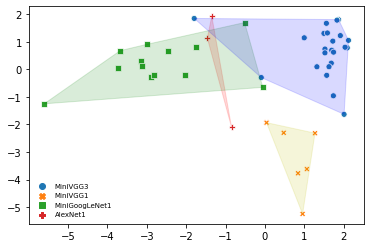

In [17]:
make_dataset_map_plot(squeezenet_X, best_architectures)

In [18]:
%%time

squeezenet_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(squeezenet_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(squeezenet_X[test_index])
    )[0]
    squeezenet_rf_recommendations[task] = recommended_architecture

CPU times: user 8.02 s, sys: 16.4 ms, total: 8.03 s
Wall time: 8.03 s


In [19]:
%%time

squeezenet_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(squeezenet_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(squeezenet_X[test_index])
    )[0]
    squeezenet_knn_recommendations[task] = recommended_architecture

CPU times: user 80.9 ms, sys: 183 µs, total: 81.1 ms
Wall time: 80.9 ms


In [20]:
with open(BASE_RECOMMENDATIONS_PATH / 'gt.pkl', 'rb') as f:
    gt_recommendations = pickle.load(f)

In [21]:
with open(BASE_RECOMMENDATIONS_PATH / 'handcraft_rf.pkl', 'rb') as f:
    handcraft_rf_recommendations = pickle.load(f)

In [22]:
with open(BASE_RECOMMENDATIONS_PATH / 'handcraft_knn.pkl', 'rb') as f:
    handcraft_knn_recommendations = pickle.load(f)

In [23]:
with open(BASE_RECOMMENDATIONS_PATH / 'oner.pkl', 'rb') as f:
    oner_recommendations = pickle.load(f)

In [24]:
with open(BASE_RECOMMENDATIONS_PATH / 'random.pkl', 'rb') as f:
    random_recommendations = pickle.load(f)

In [25]:
def make_results(recommendations):
    results = {}
    for task in TASKS:
        best_architecture = ranking_architectures[task][0]
        worst_architecture = ranking_architectures[task][-1]
        recommended_architecture = recommendations[task]
        results[task] = {
            'Ranking_architectures': ', '.join(ranking_architectures[task]),
            'Recommendation_rank': ordinal(ranking_architectures[task].index(recommended_architecture) + 1),
            'P_value[best]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][best_architecture]['accuracy']
            )[1],
            'P_value[worst]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][worst_architecture]['accuracy']
            )[1],
            'Architecture[recommended]': recommended_architecture,
            'Architecture[best]': best_architecture,
            'Architecture[worst]': worst_architecture,
            'Accuracy_avg[recommended]': metrics_avg[task][recommended_architecture]['accuracy'],
            'Accuracy_avg[best]': metrics_avg[task][best_architecture]['accuracy'],
            'Accuracy_avg[worst]': metrics_avg[task][worst_architecture]['accuracy'],
            'Precision_avg[recommended]': metrics_avg[task][recommended_architecture]['precision'],
            'Precision_avg[best]': metrics_avg[task][best_architecture]['precision'],
            'Precision_avg[worst]': metrics_avg[task][worst_architecture]['precision'],
            'Recall_avg[recommended]': metrics_avg[task][recommended_architecture]['recall'],
            'Recall_avg[best]': metrics_avg[task][best_architecture]['recall'],
            'Recall_avg[worst]': metrics_avg[task][worst_architecture]['recall'],
            'F1_avg[recommended]': metrics_avg[task][recommended_architecture]['f1'],
            'F1_avg[best]': metrics_avg[task][best_architecture]['f1'],
            'F1_avg[worst]': metrics_avg[task][worst_architecture]['f1']
        }
    return results

In [26]:
gt_results = make_results(gt_recommendations)
handcraft_rf_results = make_results(handcraft_rf_recommendations)
handcraft_knn_results = make_results(handcraft_knn_recommendations)
squeezenet_rf_results = make_results(squeezenet_rf_recommendations)
squeezenet_knn_results = make_results(squeezenet_knn_recommendations)

In [27]:
gt_results_df = pd.DataFrame(gt_results).T.rename_axis('Task').reset_index()
handcraft_rf_results_df = pd.DataFrame(handcraft_rf_results).T.rename_axis('Task').reset_index()
handcraft_knn_results_df = pd.DataFrame(handcraft_knn_results).T.rename_axis('Task').reset_index()
squeezenet_rf_results_df = pd.DataFrame(squeezenet_rf_results).T.rename_axis('Task').reset_index()
squeezenet_knn_results_df = pd.DataFrame(squeezenet_knn_results).T.rename_axis('Task').reset_index()

In [28]:
oner_results_10_executions = [
    make_results(recommendations)
    for recommendations in oner_recommendations
]

In [29]:
random_results_10_executions = [
    make_results(recommendations)
    for recommendations in random_recommendations
]

In [30]:
oner_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in oner_results_10_executions
], ignore_index=True)

In [31]:
random_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in random_results_10_executions
], ignore_index=True)

In [32]:
gt_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",1st,0.484868,9.13359e-05,MiniVGG1,MiniVGG1,ResNet10,0.91925,0.91925,0.8848,0.878482,0.878482,0.843588,0.9418,0.9418,0.8753,0.921148,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [33]:
gt_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    45
Name: Task, dtype: int64

In [34]:
gt_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [35]:
gt_results_df.groupby('Architecture[best]').Task.count()

Architecture[best]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [36]:
gt_results_df.groupby('Architecture[worst]').Task.count()

Architecture[worst]
AlexNet1            1
MiniVGG1            4
ResNet10            6
SmallSqueezeNet    34
Name: Task, dtype: int64

In [37]:
handcraft_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",2nd,0.424914,8.78078e-05,MiniGoogLeNet1,MiniVGG3,ResNet10,0.96525,0.963,0.9447,0.953657,0.945098,0.923633,0.9553,0.9663,0.9363,0.96488,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [38]:
handcraft_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    23
2nd    13
3rd     5
4th     3
6th     1
Name: Task, dtype: int64

In [39]:
handcraft_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
MiniGoogLeNet1    12
MiniVGG1           4
MiniVGG3          29
Name: Task, dtype: int64

In [40]:
squeezenet_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",3rd,0.136428,0.00158141,MiniGoogLeNet1,MiniVGG3,ResNet10,0.9656,0.96305,0.95595,0.95172,0.934987,0.937775,0.961,0.9913,0.9518,0.964927,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",2nd,0.324704,0.000743288,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.9746,0.97695,0.90715,0.959649,0.961333,0.890751,0.9831,0.9875,0.8509,0.975034,0.977209,0.856313


In [41]:
squeezenet_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    17
2nd    16
3rd     7
4th     4
6th     1
Name: Task, dtype: int64

In [42]:
squeezenet_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
MiniGoogLeNet1    10
MiniVGG1           3
MiniVGG3          32
Name: Task, dtype: int64

In [43]:
handcraft_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0651403,0.0186382,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9396,0.94775,0.8408,0.919533,0.915364,0.816722,0.927,0.9735,0.94,0.938489,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [44]:
handcraft_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    16
2nd    17
3rd     7
4th     5
Name: Task, dtype: int64

In [45]:
handcraft_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           1
MiniGoogLeNet1    15
MiniVGG1           1
MiniVGG3          28
Name: Task, dtype: int64

In [46]:
squeezenet_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",3rd,0.136428,0.00158141,MiniGoogLeNet1,MiniVGG3,ResNet10,0.9656,0.96305,0.95595,0.95172,0.934987,0.937775,0.961,0.9913,0.9518,0.964927,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0651403,0.0186382,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9396,0.94775,0.8408,0.919533,0.915364,0.816722,0.927,0.9735,0.94,0.938489,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",2nd,0.324704,0.000743288,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.9746,0.97695,0.90715,0.959649,0.961333,0.890751,0.9831,0.9875,0.8509,0.975034,0.977209,0.856313


In [47]:
squeezenet_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    15
2nd    13
3rd     8
4th     7
5th     1
6th     1
Name: Task, dtype: int64

In [48]:
squeezenet_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           2
MiniGoogLeNet1    17
MiniVGG1           5
MiniVGG3          21
Name: Task, dtype: int64

In [49]:
oner_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",2nd,0.484914,0.000121743,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9719,0.97175,0.87925,0.956602,0.953785,0.85842,0.9766,0.9827,0.808,0.972037,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",1st,0.484868,9.13359e-05,MiniVGG1,MiniVGG1,ResNet10,0.91925,0.91925,0.8848,0.878482,0.878482,0.843588,0.9418,0.9418,0.8753,0.921148,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",2nd,0.0808284,0.00405156,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9439,0.95015,0.9046,0.910412,0.920075,0.872486,0.9694,0.9716,0.8927,0.945516,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",5th,9.13359e-05,0.0928556,MiniVGG1,MiniGoogLeNet1,SmallSqueezeNet,0.89945,0.96365,0.91945,0.836805,0.945979,0.89732,0.9932,0.9657,0.8919,0.908942,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",4th,0.000842869,0.410132,SmallSqueezeNet,MiniGoogLeNet1,AlexNet1,0.97125,0.9813,0.97055,0.957307,0.974671,0.96372,0.9728,0.9763,0.9552,0.971265,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",6th,0.000842869,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.93615,0.9801,0.93615,0.921241,0.976707,0.921241,0.914,0.9671,0.914,0.934866,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",6th,0.000285888,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.92565,0.97825,0.92565,0.896233,0.970667,0.896233,0.9546,0.9724,0.9546,0.930716,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",6th,0.000740226,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.88885,0.97565,0.88885,0.866129,0.963455,0.866129,0.9128,0.978,0.9128,0.897996,0.975767,0.897996


In [50]:
oner_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st     61
2nd     53
3rd     48
4th     81
5th    113
6th     94
Name: Task, dtype: int64

In [51]:
oner_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st     6.1
2nd     5.3
3rd     4.8
4th     8.1
5th    11.3
6th     9.4
Name: Task, dtype: float64

In [52]:
oner_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
MiniGoogLeNet1      90
MiniVGG1            90
MiniVGG3            45
ResNet10           135
SmallSqueezeNet     90
Name: Task, dtype: int64

In [53]:
oner_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
MiniGoogLeNet1      9.0
MiniVGG1            9.0
MiniVGG3            4.5
ResNet10           13.5
SmallSqueezeNet     9.0
Name: Task, dtype: float64

In [54]:
random_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",6th,0.000503988,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.87925,0.97175,0.87925,0.85842,0.953785,0.85842,0.808,0.9827,0.808,0.824166,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",3rd,0.0152567,0.00255436,AlexNet1,MiniVGG3,SmallSqueezeNet,0.9446,0.95015,0.9046,0.9154,0.920075,0.872486,0.958,0.9716,0.8927,0.945391,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",4th,9.08256e-05,0.395592,ResNet10,MiniGoogLeNet1,SmallSqueezeNet,0.9332,0.96365,0.91945,0.900529,0.945979,0.89732,0.946,0.9657,0.8919,0.934192,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",2nd,0.424914,8.78078e-05,MiniGoogLeNet1,MiniVGG3,ResNet10,0.96525,0.963,0.9447,0.953657,0.945098,0.923633,0.9553,0.9663,0.9363,0.96488,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",1st,0.484776,0.00138271,MiniGoogLeNet1,MiniGoogLeNet1,AlexNet1,0.9813,0.9813,0.97055,0.974671,0.974671,0.96372,0.9763,0.9763,0.9552,0.981136,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",2nd,0.010446,0.0140343,ResNet10,MiniVGG3,SmallSqueezeNet,0.9751,0.9801,0.93615,0.963367,0.976707,0.921241,0.9753,0.9671,0.914,0.975139,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",4th,0.22459,0.00109688,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96425,0.97825,0.92565,0.947815,0.970667,0.896233,0.9823,0.9724,0.9546,0.967171,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",4th,0.000380759,0.395668,AlexNet1,MiniVGG3,SmallSqueezeNet,0.95585,0.97565,0.88885,0.945435,0.963455,0.866129,0.9339,0.978,0.9128,0.954731,0.975767,0.897996


In [55]:
random_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    78
2nd    81
3rd    73
4th    73
5th    73
6th    72
Name: Task, dtype: int64

In [56]:
random_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st    7.8
2nd    8.1
3rd    7.3
4th    7.3
5th    7.3
6th    7.2
Name: Task, dtype: float64

In [57]:
random_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           66
MiniGoogLeNet1     89
MiniVGG1           70
MiniVGG3           79
ResNet10           71
SmallSqueezeNet    75
Name: Task, dtype: int64

In [58]:
random_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
AlexNet1           6.6
MiniGoogLeNet1     8.9
MiniVGG1           7.0
MiniVGG3           7.9
ResNet10           7.1
SmallSqueezeNet    7.5
Name: Task, dtype: float64

In [59]:
algorithms_recommendations_dfs = {
    'GT': gt_results_df,
    'handcraft_RF': handcraft_rf_results_df,
    'squeezenet_RF': squeezenet_rf_results_df,
    'handcraft_KNN': handcraft_knn_results_df,
    'squeezenet_KNN': squeezenet_knn_results_df,
    'OneR': oner_results_df,
    'Random': random_results_df
}

In [60]:
metrics_dfs = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    metrics_dfs[algorithm] = recommendations_df.groupby('Task').apply(np.mean).reset_index()

In [61]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_mean': np.mean(metrics_df['Accuracy_avg[recommended]']),
        'Accuracy_std': np.std(metrics_df['Accuracy_avg[recommended]']),
        'Precision_mean': np.mean(metrics_df['Precision_avg[recommended]']),
        'Precision_std': np.std(metrics_df['Precision_avg[recommended]']),
        'Recall_mean': np.mean(metrics_df['Recall_avg[recommended]']),
        'Recall_std': np.std(metrics_df['Recall_avg[recommended]']),
        'F1_mean': np.mean(metrics_df['F1_avg[recommended]']),
        'F1_std': np.std(metrics_df['F1_avg[recommended]'])
    }
pd.DataFrame(data).T

,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std
GT,0.946940,0.037275,0.923003,0.051634,0.954076,0.038517,0.947482,0.037054
handcraft_RF,0.941507,0.039467,0.917396,0.050828,0.943640,0.055851,0.941129,0.041669
squeezenet_RF,0.940247,0.042113,0.916598,0.052035,0.939902,0.065521,0.939167,0.046762
handcraft_KNN,0.941791,0.036199,0.917814,0.048808,0.944056,0.042035,0.941651,0.036437
squeezenet_KNN,0.936809,0.047774,0.913010,0.058075,0.934776,0.074257,0.935215,0.053776
OneR,0.911848,0.056367,0.882826,0.068894,0.914304,0.056770,0.909998,0.057374
Random,0.919507,0.053932,0.891692,0.066233,0.923963,0.053693,0.918661,0.054575


In [62]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(10 if algorithm in {'Random', 'OneR'} else 1)
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,squeezenet_RF,handcraft_KNN,squeezenet_KNN,OneR,Random
1st,45.0,23.0,17.0,16.0,15.0,6.1,7.8
2nd,0.0,13.0,16.0,17.0,13.0,5.3,8.1
3rd,0.0,5.0,7.0,7.0,8.0,4.8,7.3
4th,0.0,3.0,4.0,5.0,7.0,8.1,7.3
5th,0.0,0.0,0.0,0.0,1.0,11.3,7.3
6th,0.0,1.0,1.0,0.0,1.0,9.4,7.2


In [63]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(len(recommendations_df))
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,squeezenet_RF,handcraft_KNN,squeezenet_KNN,OneR,Random
1st,1.0,0.511111,0.377778,0.355556,0.333333,0.135556,0.173333
2nd,0.0,0.288889,0.355556,0.377778,0.288889,0.117778,0.180000
3rd,0.0,0.111111,0.155556,0.155556,0.177778,0.106667,0.162222
4th,0.0,0.066667,0.088889,0.111111,0.155556,0.180000,0.162222
5th,0.0,0.000000,0.000000,0.000000,0.022222,0.251111,0.162222
6th,0.0,0.022222,0.022222,0.000000,0.022222,0.208889,0.160000


In [64]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_p_value': mannwhitneyu(
            metrics_df['Accuracy_avg[recommended]'],
            metrics_df['Accuracy_avg[best]']
        )[1],
        'Precision_p_value': mannwhitneyu(
            metrics_df['Precision_avg[recommended]'],
            metrics_df['Precision_avg[best]']
        )[1],
        'Recall_p_value': mannwhitneyu(
            metrics_df['Recall_avg[recommended]'],
            metrics_df['Recall_avg[best]']
        )[1],
        'F1_p_value': mannwhitneyu(
            metrics_df['F1_avg[recommended]'],
            metrics_df['F1_avg[best]']
        )[1]
    }
pd.DataFrame(data)

,GT,handcraft_RF,squeezenet_RF,handcraft_KNN,squeezenet_KNN,OneR,Random
Accuracy_p_value,0.49839,0.164398,0.158479,0.113811,0.130979,0.000160,0.001206
Precision_p_value,0.49839,0.197264,0.192819,0.180901,0.149863,0.000660,0.002964
Recall_p_value,0.49839,0.240039,0.206354,0.083790,0.133571,0.000012,0.000361
F1_p_value,0.49839,0.153648,0.144290,0.098311,0.112266,0.000120,0.000717


In [65]:
def make_cd(metric):
    algorithms = list(metrics_dfs.keys())
    data = [
        metrics_dfs[algorithm][metric].tolist()
        for algorithm in algorithms
    ]
    result_df = posthoc_nemenyi(data)
    result_df.index, result_df.columns = algorithms, algorithms
    names = algorithms
    avranks = (1 - np.abs(result_df['GT'])) * 5 + 1
    cd = Orange.evaluation.compute_CD(avranks, 45)
    print('cd:', cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd)
    plt.savefig(OUTPUT_PATH / f'cd_{metric}.png', dpi=1200, bbox_inches='tight')
    plt.show()

cd: 1.3427239947686223


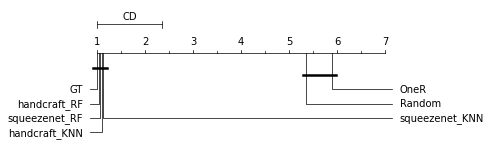

In [66]:
make_cd('Accuracy_avg[recommended]')

cd: 1.3427239947686223


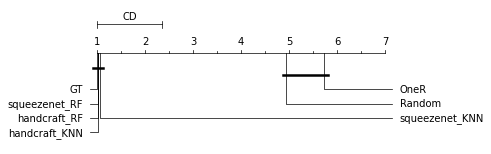

In [67]:
make_cd('Precision_avg[recommended]')

cd: 1.3427239947686223


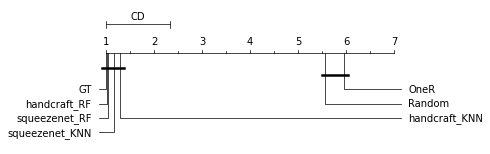

In [68]:
make_cd('Recall_avg[recommended]')

cd: 1.3427239947686223


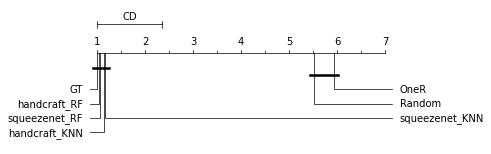

In [69]:
make_cd('F1_avg[recommended]')

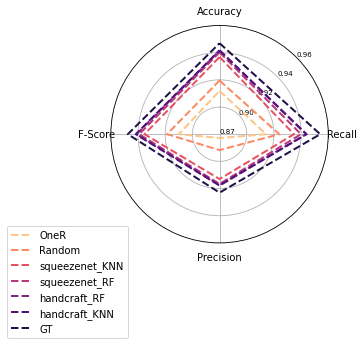

In [70]:
data = {
    'Algorithm': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F-Score': []
}

for algorithm, metrics_df in metrics_dfs.items():
    data['Algorithm'].append(algorithm)
    data['Recall'].append(np.mean(metrics_df['Recall_avg[recommended]']))
    data['Accuracy'].append(np.mean(metrics_df['Accuracy_avg[recommended]']))
    data['F-Score'].append(np.mean(metrics_df['F1_avg[recommended]']))
    data['Precision'].append(np.mean(metrics_df['Precision_avg[recommended]']))

df = pd.DataFrame(data).sort_values(by='Accuracy').reset_index(drop=True)

# ------- PART 1: Create background

# number of variable
categories = list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(45)
plt.yticks([0.88, 0.9, 0.92, 0.94, 0.96], ["0.87", "0.90", "0.92", "0.94", "0.96"], color="black", size=7)
plt.ylim(0.88, 0.96)

# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

colors = sns.color_palette('magma', len(df))

for i in range(len(df)):
    algorithm = df.loc[i]['Algorithm']
    values = df.loc[i].drop('Algorithm').values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        linewidth=2,
        linestyle='dashed',
        label=algorithm,
        color=colors.pop()
    )

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig(OUTPUT_PATH / 'radar.png', dpi=1200, bbox_inches='tight')
plt.show()